### Load Data

In [1]:
from zipfile import ZipFile
import pandas as pd

path = "youtube_comments_climate_change/videoinfo_VbiRNT_gWUQ_2020_01_16-10_08_40_comments.tab - videoinfo_VbiRNT_gWUQ_2020_01_16-10_08_40_comments.tab.csv"
data = pd.read_csv(path, sep=",", encoding='utf-8')
data = data.dropna(subset=['text', 'authorName'])

list(data.columns)

['id',
 'replyCount',
 'likeCount',
 'publishedAt',
 'authorName',
 'text',
 'authorChannelId',
 'authorChannelUrl',
 'isReply',
 'isReplyTo',
 'isReplyToName']

In [2]:
data=data.drop(['id','replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1)
data.head()

,publishedAt,authorName,text,isReply
0,2020-01-16 09:01:08,Lee McLellan,If all the ice melts surely the tilt of the ea...,0
1,2020-01-16 06:16:07,Aakash Majumdar,The scariest part of the video is the music......,0
2,2020-01-15 10:50:21,Glenn Davies,New Zealand be like...&quot;are we good?&quot;...,0
3,2020-01-15 08:35:50,Shane Meyer,Step #1: Taxes... Step #2: ???... Step #3: Utopia,0
4,2020-01-15 02:00:30,Rennie Allen,Strange how Hudson&#39;s Bay stayed the same s...,0


## Clean Data

### Remove HTML Tags

In [3]:
from html2text import HTML2Text
from tqdm import tqdm

tqdm.pandas()

h = HTML2Text()
h.ignore_links = True

data['text'] = data['text'].progress_apply(lambda x: h.handle(x))

/usr/local/lib/python3.8/site-packages/tqdm/std.py:725: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 25914/25914 [00:02<00:00, 10413.07it/s]


### Remove Links

In [5]:
http_link_pattern = r'http\S+'
bitly_link_pattern = r'bit.ly/\S+'
data['text'] = data['text'].str.replace(http_link_pattern, '')
data['text'] = data['text'].str.replace(bitly_link_pattern, '')
for i, row in data.iterrows():
    data.at[i,'text'] = data.at[i,'text'].replace("\n", " ")
    data.at[i,'text'] = data.at[i,'text'].replace("\t", " ")

### Remove user names

TODO: Speed up, takes 3 min atm

In [6]:
import re

keep_names = ["earth", "Tide", "Geologist", "A Person", "adventure", "Sun", "The United States Of America"] #user names we want to keep
user_names = [name for name in data['authorName'].unique() if (len(name)> 3 and name not in keep_names)]

data['cleaned'] = data['text'].str.replace('|'.join(map(re.escape, user_names)), '')

In [8]:
#data.to_csv(path_or_buf="youtube_comments_climate_change/cleaned_data.csv")

Only user names consisting of more than 3 char are removed to avoid joining words.

In [6]:
"s s" in user_names

False

In [7]:
data['cleaned']

0        If all the ice melts surely the tilt of the ea...
1        The scariest part of the video is the music......
2            New Zealand be like..."are we good?" 🤷‍♂️\n\n
3        Step #1: Taxes... Step #2: ???... Step #3: Uto...
4        Strange how Hudson's Bay stayed the same size....
                               ...                        
25912                                               @ \n\n
25913    And tought it would be a big deal. Plenty land...
25914                   Scary! Music helped but still.\n\n
25915    Yay!! Valdosta sinks and my farm becomes expen...
25916    I have been vacationing in the Keys in Florida...
Name: cleaned, Length: 25914, dtype: object

### More cleaning and tokenizing

In [7]:
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

def clean_text(text):
    text = text.lower()
    text = re.sub('['+punctuation + ']+', ' ', text) # strip punctuation
    text = re.sub('\s+', ' ', text) # remove double spacing
    text = re.sub('([0-9]+)', '', text) # remove numbers
    return text

In [10]:
import nltk
#nltk.download('punkt')
from tqdm import tqdm
import gensim
from gensim.utils import simple_preprocess

tqdm.pandas()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))

data_cleaned = data['cleaned'].progress_apply(clean_text)
data_words = list(sent_to_words(data_cleaned))

/usr/local/lib/python3.8/site-packages/tqdm/std.py:725: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 25914/25914 [00:00<00:00, 59628.21it/s]


Every comment ends up as a "cleaned" list of words.

In [13]:
data_words[0]

['if',
 'all',
 'the',
 'ice',
 'melts',
 'surely',
 'the',
 'tilt',
 'of',
 'the',
 'earth',
 'will',
 'also',
 'change',
 'because',
 'of',
 'the',
 'weight',
 'diffrence',
 'at',
 'both',
 'poles',
 'and',
 'would',
 'this',
 'affect',
 'the',
 'land',
 'mass',
 'to',
 'change',
 'also']

## Topic Modelling

### LDA

An n-gram is a contiguous sequence of items in this case words. A bigram consists of two words, a trigram of three words.

The gensim Phrase detection automatically detects common sequences.

Important params for these n-grams are min_count and threshold. The higher these params harder it is for words to be combined. 

In [11]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)

# Exporting the trained model means faster processing BUT model updates no longer possible.
bigram_mod = gensim.models.phrases.Phraser(bigram)

For using manually assembled stoplist, exchange "stop_words" for "stop_words_manually" in line 11 

In [12]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
path = "youtube_comments_climate_change/stoplist.txt"
with open(path, encoding="utf16") as f:
  stop_words_manually = f.read().splitlines()

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(elem)) if word not in stop_words] for elem in texts]

def make_bigrams(texts):
    return [bigram_mod[elem] for elem in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [26]:
import spacy

data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load("en", disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

During lemmatization only nouns, adjectives, verbs, and adverbs are kept.

In [27]:
data_lemmatized[0]

['ice',
 'melt',
 'surely',
 'tilt',
 'earth',
 'also',
 'change',
 'weight',
 'diffrence',
 'pole',
 'would',
 'affect',
 'land',
 'mass',
 'change',
 'also']

The gensim LDA model needs dictionary(id2word) and corpus. The dictionary creates an unique id for all words, the corpus maps the id to the number of occurences in the model.

In [28]:
import gensim.corpora as corpora

id2word = corpora.Dictionary(data_lemmatized)

texts = data_lemmatized

corpus = [id2word.doc2bow(text) for text in texts]

In [19]:
corpus[0]

[(0, 1),
 (1, 2),
 (2, 2),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1)]

In [20]:
id2word[0]

'affect'

In [21]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('affect', 1),
  ('also', 2),
  ('change', 2),
  ('diffrence', 1),
  ('earth', 1),
  ('ice', 1),
  ('land', 1),
  ('mass', 1),
  ('melt', 1),
  ('pole', 1),
  ('surely', 1),
  ('tilt', 1),
  ('weight', 1),
  ('would', 1)]]

Aside from corpus and dictionary, the model takes the number of topics, chunksize (number of documents to be used in each training chunk increasing chunksize speed up training), and passes (epochs) as input.

In [43]:
num_topics = 10
chunksize = 100
passes = 10

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, 
                                       random_state=100,
                                       chunksize=chunksize,
                                       passes=passes,
                                       per_word_topics=True)

In [44]:
from pprint import pprint

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.096*"would" + 0.044*"sea" + 0.037*"level" + 0.027*"rise" + 0.023*"land" + '
  '0.021*"much" + 0.018*"water" + 0.017*"area" + 0.016*"high" + 0.015*"ocean"'),
 (1,
  '0.065*"city" + 0.036*"least" + 0.020*"flood" + 0.019*"get" + 0.018*"big" + '
  '0.018*"probably" + 0.017*"sink" + 0.015*"canadian" + 0.015*"nice" + '
  '0.014*"wrong"'),
 (2,
  '0.053*"go" + 0.027*"year" + 0.015*"people" + 0.014*"human" + 0.014*"earth" '
  '+ 0.013*"die" + 0.013*"change" + 0.012*"fuck" + 0.012*"make" + 0.011*"man"'),
 (3,
  '0.127*"ice" + 0.096*"water" + 0.065*"melt" + 0.023*"level" + 0.020*"would" '
  '+ 0.013*"land" + 0.013*"earth" + 0.013*"take" + 0.012*"rise" + 0.011*"sea"'),
 (4,
  '0.091*"live" + 0.060*"happen" + 0.047*"good" + 0.030*"go" + 0.021*"video" + '
  '0.019*"thing" + 0.019*"see" + 0.016*"want" + 0.014*"never" + 0.014*"place"'),
 (5,
  '0.051*"bad" + 0.040*"say" + 0.037*"think" + 0.033*"earth" + 0.031*"people" '
  '+ 0.025*"would" + 0.021*"look" + 0.020*"really" + 0.017*"world" + '


In [24]:
from gensim.models import CoherenceModel

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # the lower the better.

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.82945704952545

Coherence Score:  0.5259367807182935


In [25]:
lda_model.bound(corpus)

-1398936.5188054368

### Hyperparameter Tuning

alpha and eta are hyperparameters that affect sparsity of the topics

[As seen here.](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)

In [29]:
def compute_coherence_values(corpus, dictionary, k, a, b):
  lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                          id2word=dictionary,
                                          num_topics=k, 
                                          random_state=100,
                                          chunksize=100,
                                          passes=10,
                                          alpha=a,
                                          eta=b)
  
  coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
  
  return (coherence_model_lda.get_coherence(), lda_model.log_perplexity(corpus))

In [33]:
import numpy as np
import tqdm
from gensim.models import CoherenceModel

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)

corpus_sets = [corpus] 

corpus_title = ['100% Corpus']

model_results = {'Validation_Set': [],
              'Topics': [],
              'Alpha': [],
              'Beta': [],
              'Coherence': [],
              'Perplexity': []
              }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))

    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
      # iterate through number of topics
      for k in topics_range:
        # iterate through alpha values
        for a in alpha:
          # iterare through beta values
          for b in beta:
            # get the coherence score for the given parameters
            cv, perp = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                          k=k, a=a, b=b)
            # Save the model results
            model_results['Validation_Set'].append(corpus_title[i])
            model_results['Topics'].append(k)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)
            model_results['Perplexity'].append(perp)

            pbar.update(1)

    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()


  0%|          | 0/270 [39:04<?, ?it/s] 36.27s/it]

 55%|█████▍    | 148/270 [1:27:12<1:09:38, 34.25s/it]


100%|██████████| 270/270 [2:37:24<00:00, 34.98s/it]


#### Analyze results of hyperparameter tuning

In [37]:
path = "lda_tuning_results.csv"
lda_results = pd.read_csv(path, sep=",", encoding='utf-8')

list(lda_results.columns)

['Validation_Set', 'Topics', 'Alpha', 'Beta', 'Coherence', 'Perplexity']

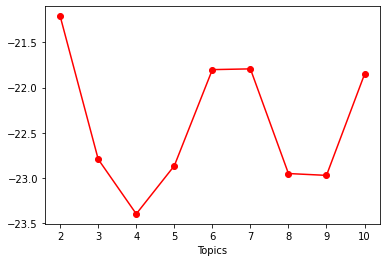

In [42]:
import matplotlib.pyplot as plt
import numpy as np

coherence = lda_results.loc[np.logical_and(lda_results.Alpha == "0.01", lda_results.Beta == "0.01")]['Coherence']
perplexity = lda_results.loc[np.logical_and(lda_results.Alpha == "0.01", lda_results.Beta == "0.01")]['Perplexity']
topics = lda_results.loc[np.logical_and(lda_results.Alpha == "0.01", lda_results.Beta == "0.01")]['Topics']

plt.plot(topics, coherence, linestyle='-', marker='o', color="blue")
plt.plot(topics, perplexity, linestyle='-', marker='o', color="red")
#plt.ylabel('Coherence')
plt.xlabel('Topics')
plt.show()

In [41]:
lda_results.loc[lda_results.Topics == 8][['Topics', 'Alpha', 'Beta', 'Coherence']]

,Topics,Alpha,Beta,Coherence
180,8,0.01,0.01,0.586230
181,8,0.01,0.31,0.541787
182,8,0.01,0.61,0.560949
183,8,0.01,0.9099999999999999,0.639118
184,8,0.01,symmetric,0.555930
185,8,0.31,0.01,0.574038
186,8,0.31,0.31,0.528449
187,8,0.31,0.61,0.487742
188,8,0.31,0.9099999999999999,0.554823
189,8,0.31,symmetric,0.553461


In [29]:
lda_results.loc[lda_results.Topics == 4][['Topics', 'Alpha', 'Beta', 'Coherence']]

,Topics,Alpha,Beta,Coherence
60,4,0.01,0.01,0.591116
61,4,0.01,0.31,0.600162
62,4,0.01,0.61,0.570935
63,4,0.01,0.9099999999999999,0.599084
64,4,0.01,symmetric,0.598141
65,4,0.31,0.01,0.624727
66,4,0.31,0.31,0.604968
67,4,0.31,0.61,0.536059
68,4,0.31,0.9099999999999999,0.565239
69,4,0.31,symmetric,0.625758


In [30]:
lda_results.loc[lda_results.Topics == 5][['Topics', 'Alpha', 'Beta', 'Coherence']]

,Topics,Alpha,Beta,Coherence
90,5,0.01,0.01,0.614550
91,5,0.01,0.31,0.591368
92,5,0.01,0.61,0.597085
93,5,0.01,0.9099999999999999,0.614294
94,5,0.01,symmetric,0.595709
95,5,0.31,0.01,0.593819
96,5,0.31,0.31,0.543297
97,5,0.31,0.61,0.519607
98,5,0.31,0.9099999999999999,0.572068
99,5,0.31,symmetric,0.584354


In [40]:
lda_results.loc[lda_results['Coherence'].idxmax()]

Validation_Set           100% Corpus
Topics                             2
Alpha             0.9099999999999999
Beta                            0.01
Coherence                   0.685963
Perplexity                  -22.3189
Name: 15, dtype: object

In [45]:
tuned_lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.9099999999999999,
                                           eta=0.01)

In [49]:
from pprint import pprint

pprint(tuned_lda_model.print_topics())
doc_tuned_lda = tuned_lda_model[corpus]

[(0,
  '0.050*"would" + 0.048*"ice" + 0.042*"water" + 0.024*"melt" + 0.021*"level" '
  '+ 0.019*"sea" + 0.015*"year" + 0.014*"earth" + 0.014*"rise" + 0.014*"land"'),
 (1,
  '0.033*"go" + 0.021*"people" + 0.019*"live" + 0.014*"get" + 0.014*"know" + '
  '0.014*"look" + 0.013*"say" + 0.013*"country" + 0.012*"happen" + '
  '0.012*"think"')]


/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Visual representation

Each blue circle represents a topic. The larger the bubble, the more prevalent the topic.

Relatively big, non-overlapping bubbles scattered throughout the chart are desirable.

By decreasing the value of lamda, more weight is put on the ratio of frequency given the topic to overall frequency of the word.

In [48]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(tuned_lda_model, corpus, id2word)

LDAvis_prepared

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.223234  0.0       1        1  50.807541
1     -0.223234  0.0       2        1  49.192459, topic_info=      Term         Freq        Total Category  logprob  loglift
5      ice  4339.000000  4339.000000  Default  30.0000  30.0000
53   water  3820.000000  3820.000000  Default  29.0000  29.0000
13   would  4711.000000  4711.000000  Default  28.0000  28.0000
8     melt  2205.000000  2205.000000  Default  27.0000  27.0000
87      go  3098.000000  3098.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
139   move   477.394644   571.912770   Topic2  -5.2116   0.5288
211   even   743.445871  1277.390711   Topic2  -4.7686   0.1682
111  still   563.750526   925.794853   Topic2  -5.0453   0.2134
67   right   471.316089   584.536791   Topic2  -5.2244   0.4941
95    time   444.077819  1029.393603   Topic2  -5.2839  -0.1313

[145 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
81        1  0.841622  actually
81        2  0.158280  actually
186       1  1.000851       age
310       1  0.985018   already
310       2  0.014757   already
...     ...       ...       ...
235       2  0.721292     world
13        1  0.960916     would
13        2  0.039056     would
57        1  0.981728      year
57        2  0.018330      year

[154 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

### Most representative topic for each comment

In [35]:
from tqdm import tqdm

def show_comment_topics(ldamodel, corpus, texts):
    topics_data = pd.DataFrame()

    #iterate over model corpus
    for index, row in tqdm(enumerate(ldamodel[corpus])):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for i, (topic_num, prop_topic) in enumerate(row):
            if i == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topics_data = topics_data.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    topics_data.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Append original comment at the end
    contents = pd.Series(texts['text'])
    topics_data = pd.concat([topics_data, contents], axis=1)
    return(topics_data)

data_topic_keywords = show_comment_topics(tuned_lda_model, corpus, data)

25914it [01:31, 282.46it/s]


In [34]:
data_dominant_topic = data_topic_keywords.reset_index()
data_dominant_topic.columns = ['Comment Nr', 'Dominant Topic', '% of Topic in Comment', 'Keywords', 'Comment']

data_dominant_topic.loc[:, 'Dominant Topic':'Comment'].head(20)

,Dominant Topic,% of Topic in Comment,Keywords,Comment
0,2.0,0.6130,"ice, water, melt, level, would, sea, rise, lan...",If all the ice melts surely the tilt of the ea...
1,0.0,0.9124,"go, would, live, look, happen, get, country, t...",The scariest part of the video is the music......
2,0.0,0.6947,"go, would, live, look, happen, get, country, t...","New Zealand be like...""are we good?"" 🤷‍♂️\n\n"
3,0.0,0.6779,"go, would, live, look, happen, get, country, t...",Step #1: Taxes... Step #2: ???... Step #3: Uto...
4,0.0,0.8468,"go, would, live, look, happen, get, country, t...",Strange how Hudson's Bay stayed the same size....
5,0.0,0.3896,"go, would, live, look, happen, get, country, t...",Sweet I'll have ocean front property.\n\n
6,0.0,0.7965,"go, would, live, look, happen, get, country, t...",Brazil will lost 25% of territory 😂\n\n
7,0.0,0.8346,"go, would, live, look, happen, get, country, t...",Lesson learned : dont put your capitol city ne...
8,1.0,0.5983,"make, say, people, need, take, know, problem, ...",If this was an actual concern...at all...then ...
9,3.0,0.5756,"year, earth, time, change, age, climate, human...","If I was 100 years old, i'll be the first to d..."


### Most representative comments for each topic

Index shows original placement of commment

In [35]:
top_comments_df = pd.DataFrame()

with pd.option_context('display.max_colwidth', None, 'display.max_rows', 10):
    for topic in data_topic_keywords.groupby('Dominant_Topic'):
        top_comments_df = pd.concat([top_comments_df, topic[1].sort_values(['Perc_Contribution'], ascending=[0]).head(5)])

    top_comments_df.columns= ['Dominant Topic', '% of Topic in Comment', 'Keywords', 'Comment']

top_comments_df

,Dominant Topic,% of Topic in Comment,Keywords,Comment
15157,0.0,0.9719,"go, would, live, look, happen, get, country, think, bad, city",PipeGameWeak Not much. Lol\n\n
23003,0.0,0.9687,"go, would, live, look, happen, get, country, think, bad, city",I kind of like the earth's looks like this.\n\n
24008,0.0,0.9659,"go, would, live, look, happen, get, country, think, bad, city",Finalmente o Paraguai vai conseguir a tão sonhada saída por mar hehe!\n\n
20842,0.0,0.9615,"go, would, live, look, happen, get, country, think, bad, city",We do something against the rising water though ;D\n\n
24290,0.0,0.9590,"go, would, live, look, happen, get, country, think, bad, city",I lol'd when Florida showed.\n\n
115,1.0,0.9269,"make, say, people, need, take, know, problem, use, stop, world","I’m old, I never had any kids, I have money, I don’t give a D_mn. You wanna\nslow this down? Quit making babies, just practice instead.\n\n"
23295,1.0,0.9254,"make, say, people, need, take, know, problem, use, stop, world",Didn't Al Gore say that this would happen by 2013?\n\n
1374,1.0,0.9160,"make, say, people, need, take, know, problem, use, stop, world",@Paul Sinclair Buddy the human eye isn't a measuring device. It's hard to tell\ndifference unless you use the correct tools.\n\n
3135,1.0,0.9145,"make, say, people, need, take, know, problem, use, stop, world","O.M.G. WE BETTER START PAYING, HOMAGE And WORSHIPPING THE GOVERNMENT And START\nPAYING, CARBON TAX,. SO GOVERNMENT CAN SAVE US,!!! From global warming!!\n\n"
23306,1.0,0.9137,"make, say, people, need, take, know, problem, use, stop, world","@john carlisle The aquatic growth has been mechanically removed or killed\nusing expensive chemicals before now. My answer is to localize anaerobic batch\ndigestors near to where the growth is harvested and used to create by\nfermentation a bio gas rich enough in methane to use to operate a generator to\nmake electricity and once the digesting is finished the effluent is a\nfertilizer with all of the humus,potash and other compounds retained and can\nbe applied to soils as it is not hot enough to cause any damage to the growing\ncrops before and after planting, but using chemicals to kill it in the water\njust causes us worse problems further down the food chain or water intakes\nthat are only increasing our already overburdened chemical diets that the EPA\nand USDA tells us is acceptable when it is not true.The government agencies\nassigned to protect us have infiltrated by the very corporations that are only\ninterested in profits with little concern to our health or the biosphere.\n\n"


### Topic distribution over corpus

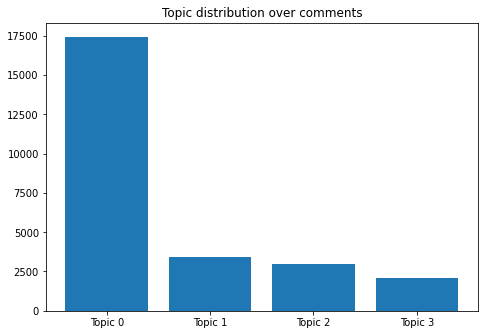

In [36]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

topic_count = data_topic_keywords['Dominant_Topic'].value_counts()

x = []
y = []

for i, topic in enumerate(topic_count):
    y.append(float(topic_count[i]))
    x.append('Topic {}'.format(i))

ax.bar(x,y)
ax.set_title('Topic distribution over comments')
plt.show()

### Show topic distribution for single comment

In [37]:
get_document_topics = tuned_lda_model.get_document_topics(corpus)

In [38]:
comment_id = int(input())

get_document_topics[comment_id]

890


[(0, 0.69444144), (1, 0.13002492), (2, 0.09751868), (3, 0.078014955)]